### 오토인코더를 활용한 노이즈 제거 기법

In [17]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

np.random.seed(1227)
(x_tr, _), (x_ts, _) = mnist.load_data()

In [18]:
image_size = x_tr.shape[1]
x_tr = np.reshape(x_tr, [-1, image_size, image_size, 1])
x_ts = np.reshape(x_ts, [-1, image_size, image_size, 1])
x_tr = x_tr.astype('float32') / 255
x_ts = x_ts.astype('float32') / 255

In [19]:
# 노이즈 추가
# loc 0.5를 중심으로 표준편차 0.5

noise = np.random.normal(loc=0.5, scale=0.5, size=x_tr.shape)
x_tr_noisy = x_tr + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_ts.shape)
x_ts_noisy = noisy = x_ts + noise

# 픽셀값이 1.0보다 크거나 0.0보다 작은값 제거
x_tr_noisy = np.clip(x_tr_noisy, 0., 1.)
x_ts_noisy = np.clip(x_ts_noisy, 0., 1.)

In [20]:
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
layer_filters = [32, 64]


In [21]:
# 인코더 모델

inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

shape = K.int_shape(x)     # second conv2d (7,7,64)
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
encoder = Model(inputs, latent, name='encoder')
encoder.summary()          # input : 28,28,1 => output 16  

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 latent_vector (Dense)       (None, 16)                50192     
                                                                 
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


In [22]:
# 2. 디코더모형

latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# second conv2d layer (-1, 7, 7, 64)


x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# 노이즈를 제거한 데이터를 출력하는 레이어

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          padding='same',
                          activation='sigmoid',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# input (None, 16) => output (None, 28, 28, 1)   

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 16)]              0         
                                                                 
 dense_4 (Dense)             (None, 3136)              53312     
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 decoder_output (Conv2DTrans  (None, 28, 28, 1)        289 

In [23]:
inputs

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'encoder_input')>

In [24]:
# 3. 오토인코더 모델 : encoder + decoder
# x - encoder
# y - decoder

autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.compile(loss='mse', optimizer='adam')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                69008     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         108993    
                                                                 
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


In [25]:
x_tr_noisy.shape, x_tr.shape, x_ts_noisy.shape, x_ts.shape 

((60000, 28, 28, 1),
 (60000, 28, 28, 1),
 (10000, 28, 28, 1),
 (10000, 28, 28, 1))

In [26]:
# train the autoencoder

autoencoder.fit(x_tr_noisy,
                x_tr,
                validation_data=(x_ts_noisy, x_ts),
                epochs=2,
                batch_size=batch_size)

Epoch 1/2
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0359 - val_loss: 0.0201
Epoch 2/2
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0191 - val_loss: 0.0177


313/313 [==============================] - 1s 3ms/step


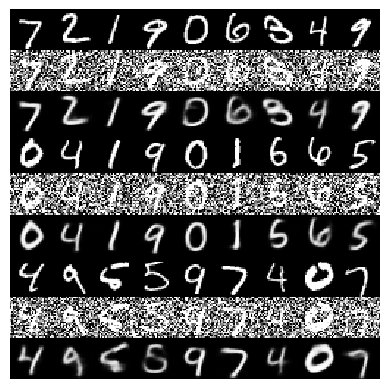

In [27]:
# 노이즈가 추가된 이미지를 입력하여 노이즈가 제거된 이미지 출력

x_decoded = autoencoder.predict(x_ts_noisy)

rows, cols = 3, 9
num = rows * cols
imgs = np.concatenate([x_ts[:num], x_ts_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)

plt.figure()
plt.axis('off')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.show()

# original => 노이즈 추가 데이터 => 노이즈 제거 데이터